In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
import matplotlib.patches as patches
import pandas as pd
from astropy.visualization import simple_norm
from astropy import wcs
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import TransformedBbox, BboxPatch, BboxConnector
from matplotlib.transforms import Bbox
from astropy.io import ascii
from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord
from radio_beam import Beam
from astropy.io import fits
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve
from astropy.convolution import convolve_fft
from reproject import reproject_interp
import cv2

In [2]:
HandCat = "/orange/adamginsburg/w51/W51_ALMA_2013.1.00308.S/tables/core_continuum_and_line.ipac"
from astropy.io import ascii
data_HandCat = ascii.read(HandCat)  
# data_HandCat

In [3]:
highres_file_B3 ='/orange/adamginsburg/w51/2017.1.00293.S/FITS/w51north_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19.mfs.I.manual.image.tt0.pbcor.fits'
hdu_highres_B3 = fits.open(highres_file_B3)
hdu_highres_B3.info()
highres_B3 = hdu_highres_B3[0].data
highres_B3 = np.squeeze(highres_B3)
header_high_B3 = hdu_highres_B3['PRIMARY'].header
hdu_highres_B3.close()
wcs_high_B3 = wcs.WCS(header_high_B3)
beam_high_B3 = Beam.from_fits_header(header_high_B3)
print(beam_high_B3)
highres = highres_B3/beam_high_B3.sr

Filename: /orange/adamginsburg/w51/2017.1.00293.S/FITS/w51north_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19.mfs.I.manual.image.tt0.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (14700, 14700, 1, 1)   float32   
Beam: BMAJ=0.06662557274104801 arcsec BMIN=0.041415508836504 arcsec BPA=-44.55107498169 deg


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [4]:
# Low resolution files
lowres_file_B3 = "/orange/adamginsburg/w51/ALMA-IMF_W51/W51-IRS2/B3/bsens/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_bsens_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits"
hdu_lowres_B3 = fits.open(lowres_file_B3)
hdu_lowres_B3.info()
lowres_B3 = hdu_lowres_B3[0].data
lowres_B3 = np.squeeze(lowres_B3)
header_low_B3 = hdu_lowres_B3['PRIMARY'].header
hdu_lowres_B3.close()
wcs_low_B3 = wcs.WCS(header_low_B3)
beam_low_B3 = Beam.from_fits_header(header_low_B3)
print(beam_low_B3)
lowres = lowres_B3/beam_low_B3.sr

Filename: /orange/adamginsburg/w51/ALMA-IMF_W51/W51-IRS2/B3/bsens/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_bsens_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      76   (3840, 3840, 1, 1)   float32   
Beam: BMAJ=0.279420912265788 arcsec BMIN=0.261483609676356 arcsec BPA=-59.6275177002 deg


In [5]:
r = data_HandCat['RA']
d = data_HandCat['Dec']
ra_list=[]
dec_list=[]
position=[]
for i in range(len(r)):
    if r[i] <= 290.92083333 and r[i] >= 290.9125:
        ra_list.append(r[i])
        position.append(i)
for i in position:
    dec_list.append(d[i])
ra=[]
dec=[]
# print(ra_list, dec_list)
for i in range(len(ra_list)):
    if dec_list[i] >= 14.516:
        dec.append(dec_list[i])
        ra.append(ra_list[i])
print(ra, dec)

[290.918733333, 290.916470833, 290.915641667, 290.915516667, 290.91595, 290.916158333, 290.916629167, 290.914658333, 290.914958333, 290.915908333, 290.91685] [14.5177611111, 14.5181527778, 14.5181222222, 14.5180972222, 14.5181194444, 14.5181083333, 14.5182694444, 14.5175916667, 14.5178138889, 14.5180083333, 14.5181722222]


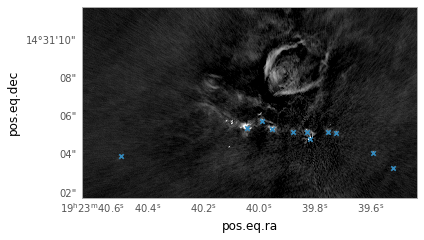

In [6]:
# Plot of high resolution image
norm=simple_norm(highres_B3, stretch='asinh', min_percent=1, max_percent=99.999)
ax = plt.subplot(projection=wcs_high_B3.celestial)
plt.imshow(highres_B3, cmap='gray', interpolation="nearest", origin="lower", norm=norm)
ax.grid(False)
# ax.set_title('Full Field high Res')
plt.scatter(ra, dec, transform=ax.get_transform('icrs'), marker='x', s=20)
plt.axis((5500,9000,6700,8700))
plt.show()

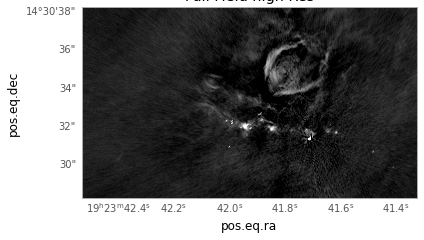

In [19]:
# Plot of high resolution image
norm=simple_norm(highres_B3, stretch='asinh', min_percent=1, max_percent=99.999)
ax = plt.subplot(projection=wcs_high_B3[6700:8700, 5500:9000].celestial)
plt.imshow(highres_B3[6700:8700, 5500:9000], cmap='gray', interpolation="nearest", origin="lower", norm=norm)
ax.grid(False)
ax.set_title('Full Field high Res')
plt.show()

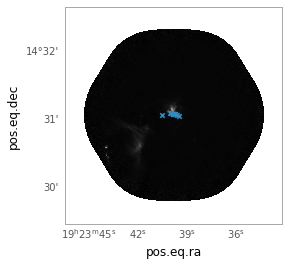

In [8]:
# Plot of high resolution image
norm=simple_norm(lowres_B3, stretch='asinh', min_percent=1, max_percent=99.999)
ax = plt.subplot(projection=wcs_low_B3.celestial)
plt.imshow(lowres_B3, cmap='gray', interpolation="nearest", origin="lower", norm=norm)
ax.grid(False)
# ax.set_title('Full Field high Res')
plt.scatter(ra, dec, transform=ax.get_transform('icrs'), marker='x', s=20)
plt.show()

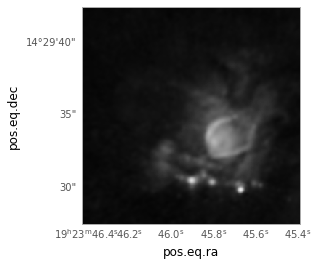

In [17]:
# Plot of high resolution image
norm=simple_norm(lowres_B3, stretch='asinh', min_percent=1, max_percent=99.999)
ax = plt.subplot(projection=wcs_low_B3[1900:2200, 1700:2000].celestial)
plt.imshow(lowres_B3[1900:2200, 1700:2000], cmap='gray', interpolation="nearest", origin="lower", norm=norm)
ax.grid(False)
# ax.set_title('Full Field high Res')
plt.show()

In [10]:
deconv_beam = beam_low_B3.deconvolve(beam_high_B3)
pix_scale = wcs.utils.proj_plane_pixel_scales(wcs_high_B3)[0]*u.deg
gauss_kern = deconv_beam.as_kernel(pix_scale)

In [21]:
array_semifull, footprint = reproject_interp((lowres_B3, wcs_low_B3.celestial), wcs_high_B3.celestial, shape_out=highres_B3[6700:8700, 5500:9000].shape)

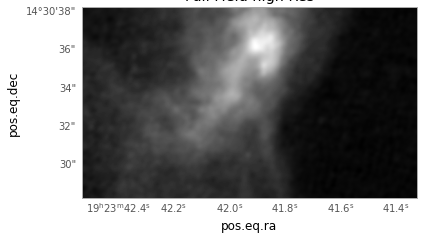

In [24]:
# Plot of high resolution image
norm=simple_norm(highres_B3, stretch='asinh', min_percent=1, max_percent=99.999)
ax = plt.subplot(projection=wcs_high_B3[6700:8700, 5500:9000].celestial)
plt.imshow(array_semifull, cmap='gray', interpolation="nearest", origin="lower")
ax.grid(False)
ax.set_title('Full Field high Res')

plt.show()

In [13]:
semifull_conv = convolve_fft(highres_B3[6700:8700, 5500:9000], gauss_kern)

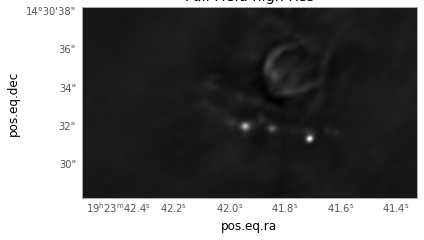

In [15]:
# Plot of high resolution image
norm=simple_norm(highres_B3, stretch='asinh', min_percent=1, max_percent=99.999)
ax = plt.subplot(projection=wcs_high_B3[6700:8700, 5500:9000].celestial)
plt.imshow(semifull_conv, cmap='gray', interpolation="nearest", origin="lower")
ax.grid(False)
ax.set_title('Full Field high Res')

plt.show()